In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
import json
import SINN_functions as sinnf

In [36]:
# Load data
datasetType = 'laplace'
extraBC = False

if datasetType == 'laplace':
    T_d = np.expand_dims(np.load("TrainingData/T_nl38_harmonic.npy"),-1)
elif datasetType == 'fluid':
    T_d = np.load("TrainingData/uvData_40_0_4.npy")
    T_d = T_d[:,1:-1,1:-1]
else:
    print('Dataset type not recognized')

T_domain,B,mesh = sinnf.GetTrainingData(T_d,extraBC)
T_train = T_domain[:-100]
B_train = B[:-100]
T_test = T_domain[-100:]
B_test = B[-100:]


In [37]:
# Load model
n_latent = 3
n_input = 1
overlap = True
layers = [60,60,60,60,60]
d_input = 1
publish = True

encoder,encoderB,decoder,P,_ = sinnf.LoadModel(n_latent,n_input,overlap,extraBC,layers,datasetType,d_input,publish)

In [38]:
err,T_recon,latent,latent_r,T_recon_l = sinnf.EvalBatch(T_test,B_test,mesh,encoder,encoderB,decoder,P,n_input,overlap)
err.mean()

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


0.0005351612296096368

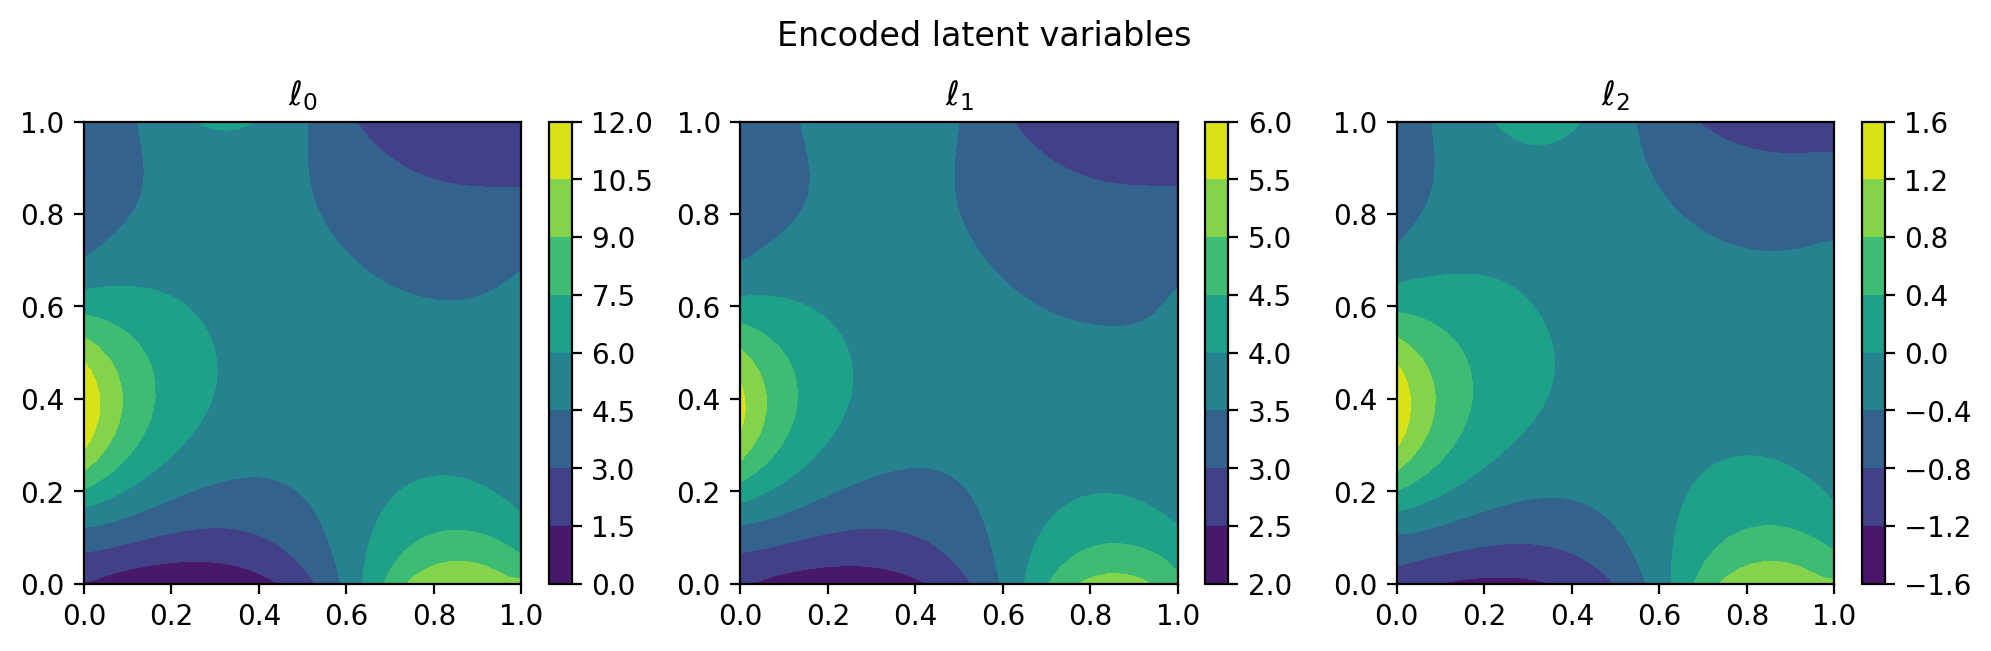

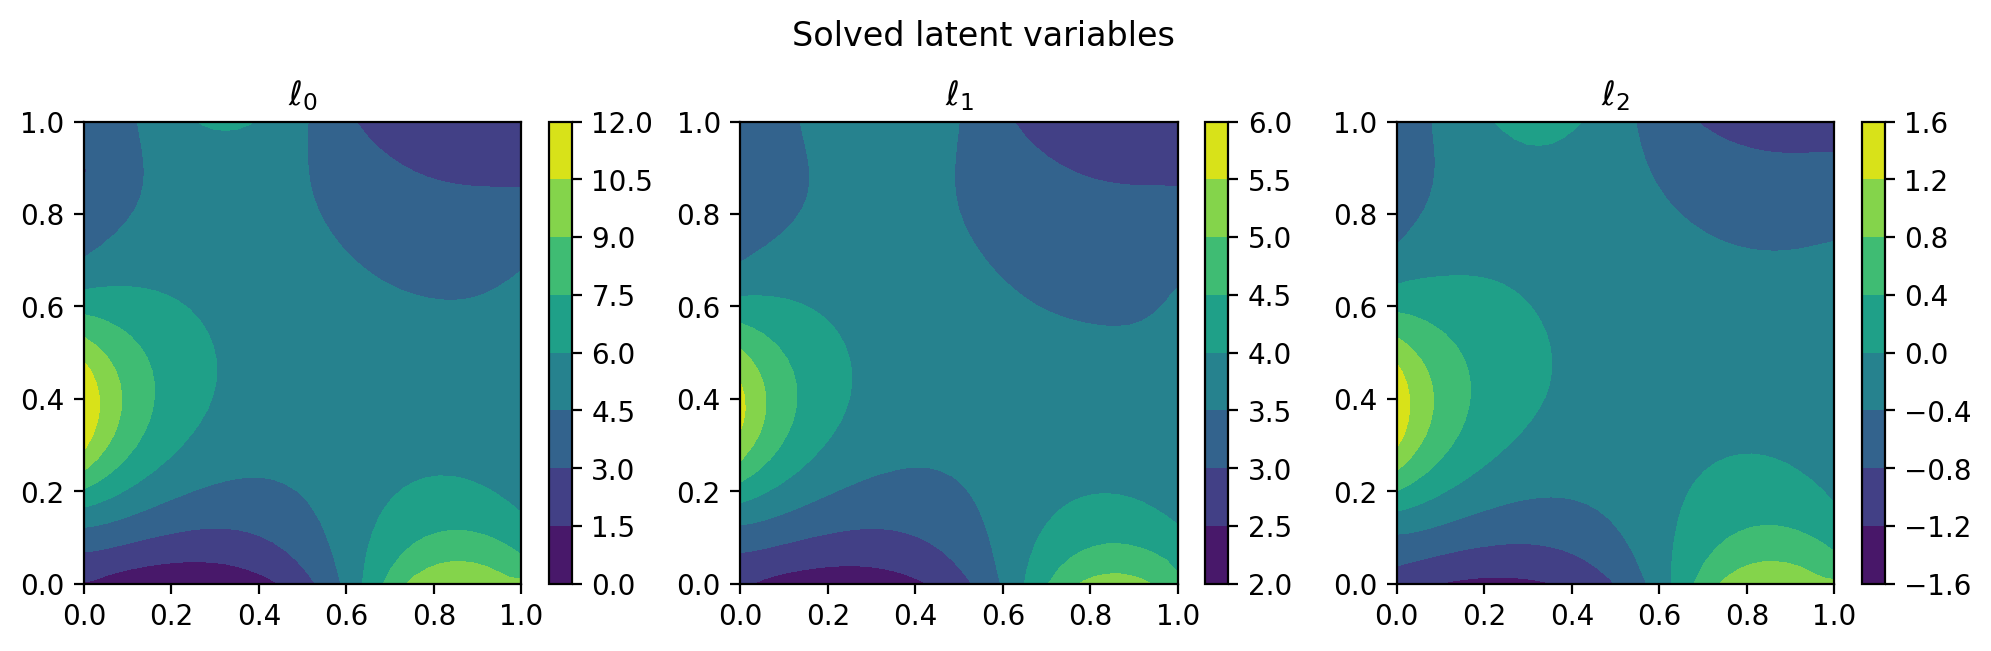

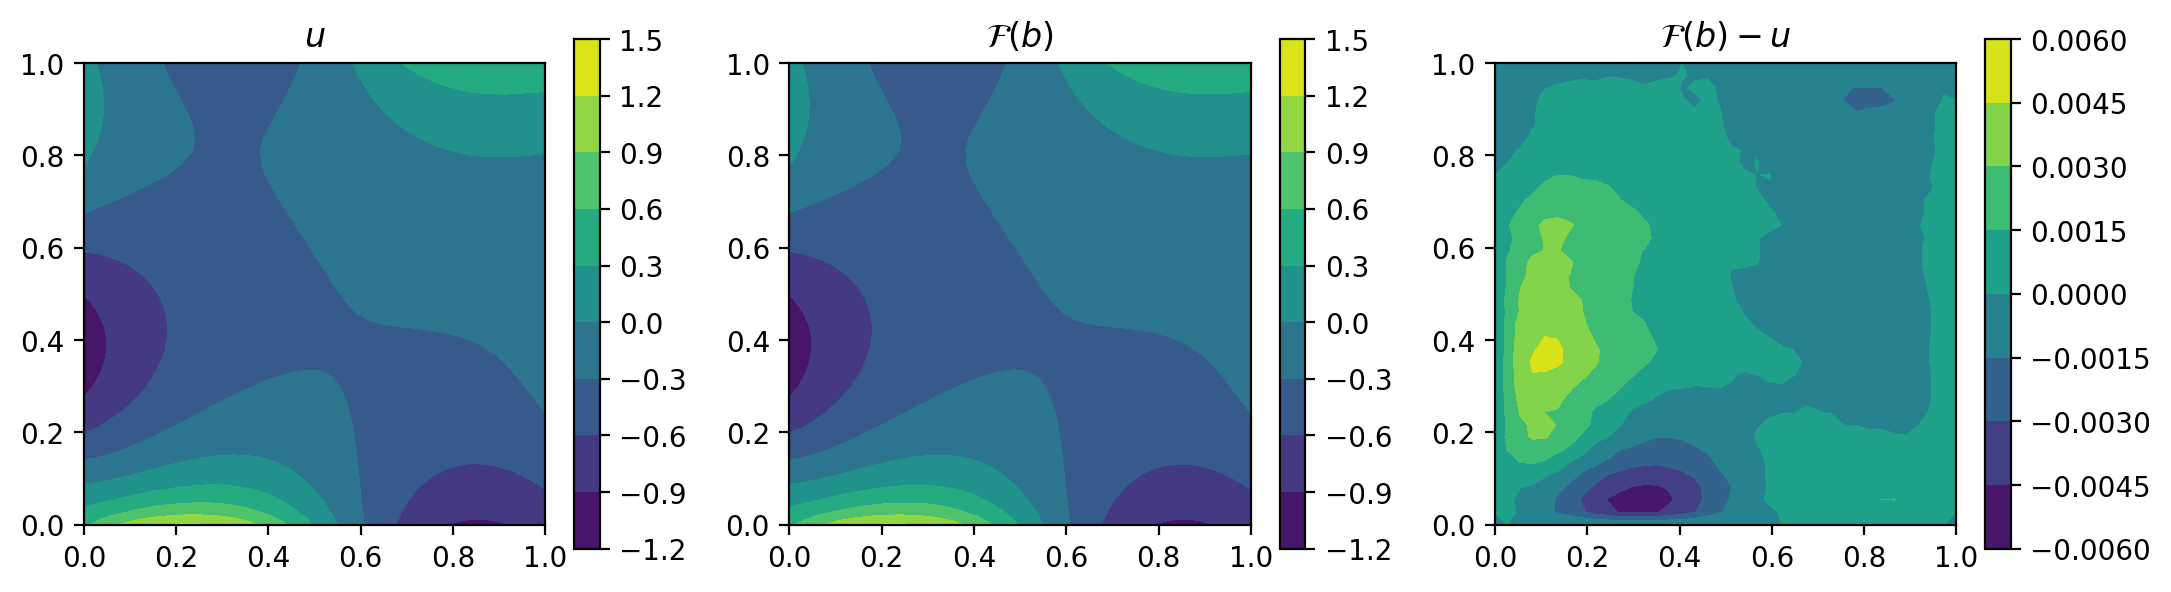

In [33]:
idx_T = 81
T_sample = T_test[idx_T]
B_sample = B_test[idx_T]

T_recon, latent, latent_r, l_mesh = sinnf.EvalOnBC(T_sample,B_sample,mesh,encoder,encoderB,decoder,P,n_input,overlap)

plt.figure(figsize=(n_latent*4,3),dpi=200)
for i in range(n_latent):
    ax = plt.subplot(1,n_latent,i+1)
    pcm = ax.contourf(l_mesh[:,:,0],l_mesh[:,:,1],latent[:,:,i])
    plt.title(r"$\ell_{"+str(i)+"}$")
    plt.colorbar(pcm)
plt.suptitle("Encoded latent variables",y=1.05)
plt.show()

plt.figure(figsize=(n_latent*4,3),dpi=200)
for i in range(n_latent):
    ax = plt.subplot(1,n_latent,i+1)
    pcm = ax.contourf(l_mesh[:,:,0],l_mesh[:,:,1],latent_r[:,:,i])
    plt.title(r"$\ell_{"+str(i)+"}$")
    plt.colorbar(pcm)
plt.suptitle("Solved latent variables",y=1.05)
plt.show()

plt.figure(figsize=(11,3),dpi=200)
plt.subplot(1,3,1)
plt.contourf(mesh[:,:,0],mesh[:,:,1],T_sample[:,:,0])
plt.gca().set_aspect('equal')
plt.title(r"$u$")
plt.colorbar()
plt.subplot(1,3,2)
plt.contourf(mesh[:,:,0],mesh[:,:,1],T_recon[:,:,0])
plt.gca().set_aspect('equal')
plt.title(r"$\mathcal{F}(b)$")
plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(mesh[:,:,0],mesh[:,:,1],T_recon[:,:,0]-T_sample[:,:,0])
plt.gca().set_aspect('equal')
plt.colorbar()
plt.title(r"$\mathcal{F}(b)-u$")
plt.tight_layout()
plt.show()